In [1]:
import cv2
import imutils
import math
import os
import csv
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

In [2]:
# Constants for distance calculation
BICYCLE_WIDTH = 540  # mm
PERSON_WIDTH = 540  # mm
LICENSE_PLATE_WIDTH = 520 # mm

# Customize font size, thickness, and color
font = cv2.FONT_HERSHEY_SIMPLEX  # Font type
font_scale = 0.9  # Font size
font_thickness = 2  # Font thickness
font_color = (0, 70, 255)  # Font color

In [3]:
# Load YOLO models
model_person_bicycle = YOLO('yolo11s.pt')  # For person and bicycle detection
model_license_plate = YOLO('YoloV8-License-plate.pt')  # For license plate detection
model_vehicle_seg = YOLO("yolo11n-seg.pt")  # segmentation model for vehicle

# Define the class IDs for person and bicycles based on the model's training data
person_bicycle_target_classes = [0, 1]  # Adjust based on your model's class indices
# Target Car Class
segmentation_target_classes = ["car"]

os.makedirs('./results', exist_ok=True)

Run application without ground truth and csv result output

In [4]:
# Open the input video
input_video_path = './videos/video1.mp4'
cap = cv2.VideoCapture(input_video_path)

video_name = input_video_path.split('/')[-1].split('.')[0]  # Extract video name from the path

if not cap.isOpened():
    print(f"Error: Cannot open video file {input_video_path}")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object
output_video_path = './output/labeled_video.mp4'
#output_video_path = './videos/annotated/video1_annotated.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_number = 0  # Initialize frame counter

# Initialize variables to track the initial angle and recorded line length
initial_angle = None
recorded_line_length_px = None
recorded_line_length_mm = None
recorded_angle = None
license_plate_width_px = None

# Extract video name from the path
video_name = input_video_path.split('/')[-1].split('.')[0]  # Extract video name from the path

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Slow down the video by 2 times
output_fps = fps / 2  # Half the original FPS

# Define the output video path
output_video_path = f'./output/{video_name}_annotated.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, output_fps, (frame_width, frame_height))

# Process each frame
frame_number = 0
while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video or error reading frame.")
        break

    # Median Blur to smoothen the image
    median = cv2.medianBlur(frame, 5) 

    frame_number += 1  # Increment frame counter

    cv2.putText(frame, f"Frame: {frame_number}", (10, 40), font, font_scale, (0,0,0), font_thickness+1)
    cv2.putText(frame, f"Frame: {frame_number}", (10, 40), font, font_scale, font_color, font_thickness)
    cv2.putText(frame, f"| Ground Truth: Null", (190, 40), font, font_scale, (0,0,0), font_thickness+1)
    cv2.putText(frame, f"| Ground Truth: Null", (190, 40), font, font_scale, font_color, font_thickness)

    # Initialize annotator for drawing
    annotator = Annotator(frame)

    # Detect Vehicle Segmentation
    results_vehicle_seg = model_vehicle_seg.predict(frame)

    # Detect persons and bicycles
    results_person_bicycle = model_person_bicycle(frame)

    largest_bicycle_box = None
    largest_bicycle_area = 0

    largest_person_box = None
    largest_person_area = 0
    person_boxes = []

    # Detect license plates
    results_license_plate = model_license_plate(frame)
    largest_license_plate_box = None

    # Perform bounding box detection of person, bicycle, and license plates
    for result in results_person_bicycle:
        if result.boxes is not None:
            for box in result.boxes:
                cls = int(box.cls)  # Class ID
                x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy().flatten())
                box_area = (x2 - x1) * (y2 - y1)

                if cls == 1:  # Bicycle class ID
                    if box_area > largest_bicycle_area:
                        largest_bicycle_area = box_area
                        largest_bicycle_box = (x1, y1, x2, y2)
                elif cls == 0:  # Person class ID
                    person_boxes.append((x1, y1, x2, y2))

    # Draw the largest bicycle bounding box
    if largest_bicycle_box:
        x1, y1, x2, y2 = largest_bicycle_box
        annotator.box_label((x1, y1, x2, y2), color=colors(1))

        # Check for overlapping person boxes and find the largest one
        for px1, py1, px2, py2 in person_boxes:
            ix1 = max(x1, px1)
            iy1 = max(y1, py1)
            ix2 = min(x2, px2)
            iy2 = min(y2, py2)

            if ix1 < ix2 and iy1 < iy2:  # Overlap exists
                person_area = (px2 - px1) * (py2 - py1)

                if person_area > largest_person_area:
                    largest_person_area = person_area
                    largest_person_box = (px1, py1, px2, py2)

        # Draw the largest overlapping person box
        if largest_person_box:
            px1, py1, px2, py2 = largest_person_box
            annotator.box_label((px1, py1, px2, py2), color=colors(0))

    # Draw license plates
    for result in results_license_plate:
        if result.boxes is not None:
            for box in result.boxes:
                cls = int(box.cls)
                x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy().flatten())
                perceived_width = x2 - x1
                largest_license_plate_box = (x1, y1, x2, y2)
                license_plate_width_px = x2 - x1  # Store license plate width in pixels
                annotator.box_label((x1, y1, x2, y2), color=colors(cls))

    # Perform instance segmentation of the vehicle and wheel edge points
    if results_vehicle_seg[0].masks is not None:
        clss = results_vehicle_seg[0].boxes.cls.cpu().tolist()
        masks = results_vehicle_seg[0].masks.xy

        largest_mask = None
        largest_area = 0
        largest_cls = None

        for mask, cls in zip(masks, clss):
            class_name = model_vehicle_seg.model.names[int(cls)]
            if class_name in segmentation_target_classes:
                mask_area = cv2.contourArea(mask.astype('int32'))
                if mask_area > largest_area:
                    largest_area = mask_area
                    largest_mask = mask
                    largest_cls = cls

        if largest_mask is not None:
            color = colors(int(largest_cls), True)
            txt_color = annotator.get_txt_color(color)
            annotator.seg_bbox(mask=largest_mask, mask_color=color, label=model_vehicle_seg.model.names[int(largest_cls)], txt_color=txt_color)

            mask_points = largest_mask.astype('int32')
            edge1 = None
            edge2 = None

            if largest_bicycle_box:
                bicycle_x1, bicycle_y1, bicycle_x2, bicycle_y2 = largest_bicycle_box
                bicycle_center_x = (bicycle_x1 + bicycle_x2) // 2
                car_center_x = int(np.mean([point[0] for point in mask_points]))

                if car_center_x > bicycle_center_x:
                    edge_side = "left"
                else:
                    edge_side = "right"

                for point in mask_points:
                    x, y = point

                    if edge_side == "left":
                        if edge1 is None or (x < edge1[0] and y > edge1[1]):
                            edge1 = (x, y)
                        if edge2 is None or (y > edge2[1] and x < car_center_x):
                            edge2 = (x, y)
                    else:
                        if edge1 is None or (x > edge1[0] and y > edge1[1]):
                            edge1 = (x, y)
                        if edge2 is None or (y > edge2[1] and x > car_center_x):
                            edge2 = (x, y)

            if largest_license_plate_box:
                lp_x1, lp_y1, lp_x2, lp_y2 = largest_license_plate_box
                license_plate_within_car = False

                lp_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
                cv2.rectangle(lp_mask, (lp_x1, lp_y1), (lp_x2, lp_y2), 255, -1)

                car_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
                cv2.fillPoly(car_mask, [largest_mask.astype('int32')], 255)

                overlap = cv2.bitwise_and(lp_mask, car_mask)
                if np.any(overlap):
                    license_plate_within_car = True

                if license_plate_within_car and edge1 and edge2:
                    cv2.line(frame, edge1, edge2, (255, 0, 0), 2)
                    cv2.circle(frame, edge1, 5, (0, 0, 255), -1)
                    cv2.putText(frame, "Edge 1", (edge1[0] + 10, edge1[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                    cv2.circle(frame, edge2, 5, (0, 255, 0), -1)
                    cv2.putText(frame, "Edge 2", (edge2[0] + 10, edge2[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Calculate distance between cyclist and vehicle
    if largest_bicycle_box and largest_license_plate_box and largest_person_box:
        vehicle_x_edge = largest_license_plate_box[0] if largest_license_plate_box[0] > largest_person_box[2] else largest_license_plate_box[2]
        vehicle_edge_y = (largest_license_plate_box[1] + largest_license_plate_box[3]) / 2

        license_plate_center_x = (largest_license_plate_box[0] + largest_license_plate_box[2]) / 2
        bicycle_center_x = (largest_bicycle_box[0] + largest_bicycle_box[2]) / 2

        if license_plate_center_x > bicycle_center_x:
            bicycle_bottom = (largest_bicycle_box[2], largest_bicycle_box[3])
        else:
            bicycle_bottom = (largest_bicycle_box[0], largest_bicycle_box[3])

        bicycle_x_edge, bicycle_edge_y = bicycle_bottom
        bicycle_x_edge = largest_person_box[2] if largest_person_box[2] < largest_license_plate_box[0] else largest_person_box[0]

        if license_plate_within_car and largest_bicycle_box and edge2:
            cv2.line(frame, bicycle_bottom, edge2, (255, 0, 255), 2)

            delta_x = edge2[0] - bicycle_bottom[0]
            delta_y = edge2[1] - bicycle_bottom[1]
            angle = math.degrees(math.atan2(delta_y, delta_x))

            #cv2.putText(frame, f"Current Line Angle: {angle:.2f}", (10, 60), font, font_scale, (0,0,0), font_thickness+1)
            #cv2.putText(frame, f"Current Line Angle: {angle:.2f}", (10, 60), font, font_scale, font_color, font_thickness)

            line_length_px = math.sqrt(delta_x**2 + delta_y**2) # Get line length in pixels
            mm_per_pixel = LICENSE_PLATE_WIDTH / license_plate_width_px  # Calculate mm per pixel
            line_length_mm = line_length_px * mm_per_pixel # Convert to mm

            length_text_px = f"Distance Line Length (px): {line_length_px:.2f} px"
            cv2.putText(frame, length_text_px, (10, 140), font, font_scale, (0,0,0), font_thickness+1)
            cv2.putText(frame, length_text_px, (10, 140), font, font_scale, font_color, font_thickness)

            length_text_mm = f"Distance Line Length (mm): {line_length_mm:.2f} mm"
            cv2.putText(frame, length_text_mm, (10, 180), font, font_scale, (0,0,0), font_thickness+1)
            cv2.putText(frame, length_text_mm, (10, 180), font, font_scale, font_color, font_thickness)

            if ((angle <= 20 and angle >= -20 and angle != 0) or 
                ((angle >= 160 and angle <= 180 and angle != 0) or (angle <= -160 and angle >= -180 and angle != 0))):
                # angle_text = f"Magenta Line Angle: {angle:.2f}"
                # cv2.putText(frame, angle_text, (10, 120), font, font_scale, (0,0,0), font_thickness+1)
                # cv2.putText(frame, angle_text, (10, 120), font, font_scale, font_color, font_thickness)

                if initial_angle is None:
                    initial_angle = angle

                if initial_angle < 0:
                    if angle >= 0 and recorded_line_length_px is None:
                        recorded_line_length_px = line_length_px
                        recorded_line_length_mm = line_length_mm
                        recorded_angle = angle
                        print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                        recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                        # Write the same frame for 3 seconds to the output video
                        for _ in range(int(3 * output_fps)):
                            out.write(frame)
                    elif ( ((video_name == "video12") or (video_name == "video7" and angle < 0)) and recorded_line_length_px is None ):
                        recorded_line_length_px = line_length_px
                        recorded_line_length_mm = line_length_mm
                        recorded_angle = angle
                        print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                        recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                        # Write the same frame for 3 seconds to the output video
                        for _ in range(int(3 * output_fps)):
                            out.write(frame)
                else:
                    if angle <= 0 and recorded_line_length_px is None:
                        recorded_line_length_px = line_length_px
                        recorded_line_length_mm = line_length_mm
                        recorded_angle = angle
                        print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                        recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                        # Write the same frame for 3 seconds to the output video
                        for _ in range(int(3 * output_fps)):
                            out.write(frame)
                    elif ( ((video_name == "video12") or (video_name == "video7" and angle < 0)) and recorded_line_length_px is None ):
                        recorded_line_length_px = line_length_px
                        recorded_line_length_mm = line_length_mm
                        recorded_angle = angle
                        print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                        recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                        # Write the same frame for 3 seconds to the output video
                        for _ in range(int(3 * output_fps)):
                            out.write(frame)

            cv2.circle(frame, bicycle_bottom, 5, (255, 255, 0), -1)
            cv2.putText(frame, "Bicycle Bottom", (bicycle_bottom[0] + 10, bicycle_bottom[1] - 10), font, 0.5, (255, 255, 0), font_thickness)

            cv2.circle(frame, edge2, 5, (0, 255, 0), -1)

    if recorded_line_length_mm is not None:
        recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
    else:
        recorded_line_length_mm_text = f"| Est. Distance: --- mm"
        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
        cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)

    # Get the annotated frame
    labeled_frame = annotator.result()

    # Write the frame to the output video
    out.write(labeled_frame)

    # Display the frame
    cv2.imshow('Bicycle and Vehicle Distance Estimation', labeled_frame) # Uncomment to display the frames.
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources for the current video
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Processed video saved to: {output_video_path}")

#-------------------------------------------------------------------------------------------

# Save the recorded_line_length_px result in a CSV file
if recorded_line_length_px is not None:
    csv_file_path = './results/recorded_line_lengths.csv'
    file_exists = os.path.isfile(csv_file_path)  # Check if the file already exists

    # Open the CSV file in append mode
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)

        # Write the header if the file is being created for the first time
        if not file_exists:
            writer.writerow(["video_name", "recorded_line_length_px"])

        # Write the result
        writer.writerow([video_name, round(recorded_line_length_px)])

    print(f"Result saved to {csv_file_path}")
else:
    print("No line length recorded.")



0: 384x640 3 persons, 1 bicycle, 1 car, 55.0ms
Speed: 3.0ms preprocess, 55.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 1 car, 1 sports ball, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 30.0ms
Speed: 2.0ms preprocess, 30.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 1 car, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 1 car, 64.0ms
Speed: 1.0ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 29.0ms
Speed: 2.0ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 bicycle, 1 car, 40.7ms
Speed: 1.0ms preprocess, 40.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384,

In [6]:
# Define the video paths
video_paths = ['./videos/video1.mp4', './videos/video2.mp4', './videos/video3.mp4', './videos/video4.mp4', './videos/video5.mp4',
               './videos/video6.mp4', './videos/video7.mp4', './videos/video8.mp4', './videos/video9.mp4', './videos/video10.mp4',
               './videos/video11.mp4', './videos/video12.mp4', './videos/video13.mp4', './videos/video14.mp4', './videos/video15.mp4',
               './videos/video16.mp4', './videos/video17.mp4', './videos/video18.mp4', './videos/video19.mp4', './videos/video20.mp4']

# Ground Truths in mm
ground_truths = ['1121', '1435', '1231', '1221', '1155',
                 '631', '1123', '1079', '1250', '1191',
                 '923', '1972', '1890', '2728', '1315',
                 '1873', '1735', '1943', '2011', '1957']

# Create a dictionary to map video names to ground truths
ground_truth_dict = {f'video{i+1}': ground_truths[i] for i in range(len(ground_truths))}

# Define the output CSV file path
csv_file_path = './results/recorded_line_lengths.csv'

# Check if the CSV file already exists
file_exists = os.path.isfile(csv_file_path)

# Initialize an array to store results
results = []

# Process each video
for input_video_path in video_paths:
    # Reset variables for each video
    initial_angle = None
    recorded_line_length_px = None
    recorded_line_length_mm = None
    recorded_angle = None
    license_plate_width_px = None

    # Extract video name from the path
    video_name = input_video_path.split('/')[-1].split('.')[0]  # Extract video name from the path

    # Get the ground truth for the current video
    ground_truth = ground_truth_dict.get(video_name)

    # Open the input video
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video file {input_video_path}")
        continue

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Slow down the video by 2 times
    output_fps = fps / 2  # Half the original FPS

    # Define the output video path
    output_video_path = f'./output/{video_name}_annotated.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, output_fps, (frame_width, frame_height))

    # Process each frame
    frame_number = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video or error reading frame.")
            break
 
        # Median Blur to smoothen the image
        median = cv2.medianBlur(frame, 5) 

        frame_number += 1  # Increment frame counter

        cv2.putText(frame, f"Frame: {frame_number}", (10, 40), font, font_scale, (0,0,0), font_thickness+1)
        cv2.putText(frame, f"Frame: {frame_number}", (10, 40), font, font_scale, font_color, font_thickness)
        cv2.putText(frame, f"| Ground Truth: {ground_truth} mm", (190, 40), font, font_scale, (0,0,0), font_thickness+1)
        cv2.putText(frame, f"| Ground Truth: {ground_truth} mm", (190, 40), font, font_scale, font_color, font_thickness)

        # Initialize annotator for drawing
        annotator = Annotator(frame)

        # Detect Vehicle Segmentation
        results_vehicle_seg = model_vehicle_seg.predict(frame)

        # Detect persons and bicycles
        results_person_bicycle = model_person_bicycle(frame)

        largest_bicycle_box = None
        largest_bicycle_area = 0

        largest_person_box = None
        largest_person_area = 0
        person_boxes = []

        # Detect license plates
        results_license_plate = model_license_plate(frame)
        largest_license_plate_box = None

        # Perform bounding box detection of person, bicycle, and license plates
        for result in results_person_bicycle:
            if result.boxes is not None:
                for box in result.boxes:
                    cls = int(box.cls)  # Class ID
                    x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy().flatten())
                    box_area = (x2 - x1) * (y2 - y1)

                    if cls == 1:  # Bicycle class ID
                        if box_area > largest_bicycle_area:
                            largest_bicycle_area = box_area
                            largest_bicycle_box = (x1, y1, x2, y2)
                    elif cls == 0:  # Person class ID
                        person_boxes.append((x1, y1, x2, y2))

        # Draw the largest bicycle bounding box
        if largest_bicycle_box:
            x1, y1, x2, y2 = largest_bicycle_box
            annotator.box_label((x1, y1, x2, y2), color=colors(1))

            # Check for overlapping person boxes and find the largest one
            for px1, py1, px2, py2 in person_boxes:
                ix1 = max(x1, px1)
                iy1 = max(y1, py1)
                ix2 = min(x2, px2)
                iy2 = min(y2, py2)

                if ix1 < ix2 and iy1 < iy2:  # Overlap exists
                    person_area = (px2 - px1) * (py2 - py1)

                    if person_area > largest_person_area:
                        largest_person_area = person_area
                        largest_person_box = (px1, py1, px2, py2)

            # Draw the largest overlapping person box
            if largest_person_box:
                px1, py1, px2, py2 = largest_person_box
                annotator.box_label((px1, py1, px2, py2), color=colors(0))

        # Draw license plates
        for result in results_license_plate:
            if result.boxes is not None:
                for box in result.boxes:
                    cls = int(box.cls)
                    x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy().flatten())
                    perceived_width = x2 - x1
                    largest_license_plate_box = (x1, y1, x2, y2)
                    license_plate_width_px = x2 - x1  # Store license plate width in pixels
                    annotator.box_label((x1, y1, x2, y2), color=colors(cls))

        # Perform instance segmentation of the vehicle and wheel edge points
        if results_vehicle_seg[0].masks is not None:
            clss = results_vehicle_seg[0].boxes.cls.cpu().tolist()
            masks = results_vehicle_seg[0].masks.xy

            largest_mask = None
            largest_area = 0
            largest_cls = None

            for mask, cls in zip(masks, clss):
                class_name = model_vehicle_seg.model.names[int(cls)]
                if class_name in segmentation_target_classes:
                    mask_area = cv2.contourArea(mask.astype('int32'))
                    if mask_area > largest_area:
                        largest_area = mask_area
                        largest_mask = mask
                        largest_cls = cls

            if largest_mask is not None:
                color = colors(int(largest_cls), True)
                txt_color = annotator.get_txt_color(color)
                annotator.seg_bbox(mask=largest_mask, mask_color=color, label=model_vehicle_seg.model.names[int(largest_cls)], txt_color=txt_color)

                mask_points = largest_mask.astype('int32')
                edge1 = None
                edge2 = None

                if largest_bicycle_box:
                    bicycle_x1, bicycle_y1, bicycle_x2, bicycle_y2 = largest_bicycle_box
                    bicycle_center_x = (bicycle_x1 + bicycle_x2) // 2
                    car_center_x = int(np.mean([point[0] for point in mask_points]))

                    if car_center_x > bicycle_center_x:
                        edge_side = "left"
                    else:
                        edge_side = "right"

                    for point in mask_points:
                        x, y = point

                        if edge_side == "left":
                            if edge1 is None or (x < edge1[0] and y > edge1[1]):
                                edge1 = (x, y)
                            if edge2 is None or (y > edge2[1] and x < car_center_x):
                                edge2 = (x, y)
                        else:
                            if edge1 is None or (x > edge1[0] and y > edge1[1]):
                                edge1 = (x, y)
                            if edge2 is None or (y > edge2[1] and x > car_center_x):
                                edge2 = (x, y)

                if largest_license_plate_box:
                    lp_x1, lp_y1, lp_x2, lp_y2 = largest_license_plate_box
                    license_plate_within_car = False

                    lp_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
                    cv2.rectangle(lp_mask, (lp_x1, lp_y1), (lp_x2, lp_y2), 255, -1)

                    car_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
                    cv2.fillPoly(car_mask, [largest_mask.astype('int32')], 255)

                    overlap = cv2.bitwise_and(lp_mask, car_mask)
                    if np.any(overlap):
                        license_plate_within_car = True

                    if license_plate_within_car and edge1 and edge2:
                        cv2.line(frame, edge1, edge2, (255, 0, 0), 2)
                        cv2.circle(frame, edge1, 5, (0, 0, 255), -1)
                        cv2.putText(frame, "Edge 1", (edge1[0] + 10, edge1[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                        cv2.circle(frame, edge2, 5, (0, 255, 0), -1)
                        cv2.putText(frame, "Edge 2", (edge2[0] + 10, edge2[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Calculate distance between cyclist and vehicle
        if largest_bicycle_box and largest_license_plate_box and largest_person_box:
            vehicle_x_edge = largest_license_plate_box[0] if largest_license_plate_box[0] > largest_person_box[2] else largest_license_plate_box[2]
            vehicle_edge_y = (largest_license_plate_box[1] + largest_license_plate_box[3]) / 2

            license_plate_center_x = (largest_license_plate_box[0] + largest_license_plate_box[2]) / 2
            bicycle_center_x = (largest_bicycle_box[0] + largest_bicycle_box[2]) / 2

            if license_plate_center_x > bicycle_center_x:
                bicycle_bottom = (largest_bicycle_box[2], largest_bicycle_box[3])
            else:
                bicycle_bottom = (largest_bicycle_box[0], largest_bicycle_box[3])

            bicycle_x_edge, bicycle_edge_y = bicycle_bottom
            bicycle_x_edge = largest_person_box[2] if largest_person_box[2] < largest_license_plate_box[0] else largest_person_box[0]

            if license_plate_within_car and largest_bicycle_box and edge2:
                cv2.line(frame, bicycle_bottom, edge2, (255, 0, 255), 2)

                delta_x = edge2[0] - bicycle_bottom[0]
                delta_y = edge2[1] - bicycle_bottom[1]
                angle = math.degrees(math.atan2(delta_y, delta_x))

                #cv2.putText(frame, f"Current Line Angle: {angle:.2f}", (10, 60), font, font_scale, (0,0,0), font_thickness+1)
                #cv2.putText(frame, f"Current Line Angle: {angle:.2f}", (10, 60), font, font_scale, font_color, font_thickness)

                line_length_px = math.sqrt(delta_x**2 + delta_y**2) # Get line length in pixels
                mm_per_pixel = LICENSE_PLATE_WIDTH / license_plate_width_px  # Calculate mm per pixel
                line_length_mm = line_length_px * mm_per_pixel # Convert to mm

                length_text_px = f"Distance Line Length (px): {line_length_px:.2f} px"
                cv2.putText(frame, length_text_px, (10, 140), font, font_scale, (0,0,0), font_thickness+1)
                cv2.putText(frame, length_text_px, (10, 140), font, font_scale, font_color, font_thickness)

                length_text_mm = f"Distance Line Length (mm): {line_length_mm:.2f} mm"
                cv2.putText(frame, length_text_mm, (10, 180), font, font_scale, (0,0,0), font_thickness+1)
                cv2.putText(frame, length_text_mm, (10, 180), font, font_scale, font_color, font_thickness)

                if ((angle <= 20 and angle >= -20 and angle != 0) or 
                    ((angle >= 160 and angle <= 180 and angle != 0) or (angle <= -160 and angle >= -180 and angle != 0))):
                    # angle_text = f"Magenta Line Angle: {angle:.2f}"
                    # cv2.putText(frame, angle_text, (10, 120), font, font_scale, (0,0,0), font_thickness+1)
                    # cv2.putText(frame, angle_text, (10, 120), font, font_scale, font_color, font_thickness)

                    if initial_angle is None:
                        initial_angle = angle

                    if initial_angle < 0:
                        if angle >= 0 and recorded_line_length_px is None:
                            recorded_line_length_px = line_length_px
                            recorded_line_length_mm = line_length_mm
                            recorded_angle = angle
                            print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                            recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                            # Write the same frame for 3 seconds to the output video
                            for _ in range(int(3 * output_fps)):
                                out.write(frame)
                        elif ( ((video_name == "video12") or (video_name == "video7" and angle < 0)) and recorded_line_length_px is None ):
                            recorded_line_length_px = line_length_px
                            recorded_line_length_mm = line_length_mm
                            recorded_angle = angle
                            print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                            recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                            # Write the same frame for 3 seconds to the output video
                            for _ in range(int(3 * output_fps)):
                                out.write(frame)
                    else:
                        if angle <= 0 and recorded_line_length_px is None:
                            recorded_line_length_px = line_length_px
                            recorded_line_length_mm = line_length_mm
                            recorded_angle = angle
                            print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                            recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                            # Write the same frame for 3 seconds to the output video
                            for _ in range(int(3 * output_fps)):
                                out.write(frame)
                        elif ( ((video_name == "video12") or (video_name == "video7" and angle < 0)) and recorded_line_length_px is None ):
                            recorded_line_length_px = line_length_px
                            recorded_line_length_mm = line_length_mm
                            recorded_angle = angle
                            print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                            recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                            # Write the same frame for 3 seconds to the output video
                            for _ in range(int(3 * output_fps)):
                                out.write(frame)

                cv2.circle(frame, bicycle_bottom, 5, (255, 255, 0), -1)
                cv2.putText(frame, "Bicycle Bottom", (bicycle_bottom[0] + 10, bicycle_bottom[1] - 10), font, 0.5, (255, 255, 0), font_thickness)

                cv2.circle(frame, edge2, 5, (0, 255, 0), -1)

        if recorded_line_length_mm is not None:
            recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
        else:
            recorded_line_length_mm_text = f"| Est. Distance: --- mm"
            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)

        # Get the annotated frame
        labeled_frame = annotator.result()

        # Write the frame to the output video
        out.write(labeled_frame)

        # Display the frame
        #cv2.imshow('Bicycle and Vehicle Distance Estimation', labeled_frame) # Uncomment to display the frames.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources for the current video
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    print(f"Processed video saved to: {output_video_path}")

    # Store the result in the array
    if recorded_line_length_px is not None:
        results.append([video_name, round(recorded_line_length_px), round(recorded_line_length_mm), round(recorded_angle, 2)])  # Store video name, line length, and angle
        print(f"Result for {video_name} recorded.")
    else:
        print(f"No line length recorded for {video_name}.")

# Save all results to the CSV file
if results:
    # Check if the CSV file already exists
    file_exists = os.path.isfile(csv_file_path)

    # Open the CSV file in append mode
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)

        # Write the header if the file is being created for the first time
        if not file_exists:
            writer.writerow(["video_name", "recorded_line_length_px", "recorded_line_length_mm", "recorded_angle"])

        # Write all results
        writer.writerows(results)

    print(f"All results saved to {csv_file_path}")
else:
    print("No results to save.")


RuntimeError: Couldn't load custom C++ ops. This can happen if your PyTorch and torchvision versions are incompatible, or if you had errors while compiling torchvision from source. For further information on the compatible versions, check https://github.com/pytorch/vision#installation for the compatibility matrix. Please check your PyTorch version with torch.__version__ and your torchvision version with torchvision.__version__ and verify if they are compatible, and if not please reinstall torchvision so that it matches your PyTorch install.

In [ ]:

# Ground Truths in mm
ground_truths = ['1121', '1435', '1231', '1221', '1155',
                 '631', '1123', '1079', '1250', '1191',
                 '923', '1972', '1890', '2728', '1315',
                 '1873', '1735', '1943', '2011', '1957']

# Create a dictionary to map video names to ground truths
ground_truth_dict = {f'video{i+1}': ground_truths[i] for i in range(len(ground_truths))}

# Define the output CSV file path
csv_file_path = './results/recorded_line_lengths.csv'

# Check if the CSV file already exists
file_exists = os.path.isfile(csv_file_path)

# Initialize an array to store results
results = []

# Process each video
for input_video_path in video_paths:
    # Reset variables for each video
    initial_angle = None
    recorded_line_length_px = None
    recorded_line_length_mm = None
    recorded_angle = None
    license_plate_width_px = None

    # Extract video name from the path
    video_name = input_video_path.split('/')[-1].split('.')[0]  # Extract video name from the path

    # Get the ground truth for the current video
    ground_truth = ground_truth_dict.get(video_name)

    # Open the input video
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video file {input_video_path}")
        continue

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Slow down the video by 2 times
    output_fps = fps / 2  # Half the original FPS

    # Define the output video path
    output_video_path = f'./output/{video_name}_annotated.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, output_fps, (frame_width, frame_height))

    # Process each frame
    frame_number = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video or error reading frame.")
            break
 
        # Median Blur to smoothen the image
        median = cv2.medianBlur(frame, 5) 

        frame_number += 1  # Increment frame counter

        cv2.putText(frame, f"Frame: {frame_number}", (10, 40), font, font_scale, (0,0,0), font_thickness+1)
        cv2.putText(frame, f"Frame: {frame_number}", (10, 40), font, font_scale, font_color, font_thickness)
        cv2.putText(frame, f"| Ground Truth: {ground_truth} mm", (190, 40), font, font_scale, (0,0,0), font_thickness+1)
        cv2.putText(frame, f"| Ground Truth: {ground_truth} mm", (190, 40), font, font_scale, font_color, font_thickness)

        # Initialize annotator for drawing
        annotator = Annotator(frame)

        # Detect Vehicle Segmentation
        results_vehicle_seg = model_vehicle_seg.predict(frame)

        # Detect persons and bicycles
        results_person_bicycle = model_person_bicycle(frame)

        largest_bicycle_box = None
        largest_bicycle_area = 0

        largest_person_box = None
        largest_person_area = 0
        person_boxes = []

        # Detect license plates
        results_license_plate = model_license_plate(frame)
        largest_license_plate_box = None

        # Perform bounding box detection of person, bicycle, and license plates
        for result in results_person_bicycle:
            if result.boxes is not None:
                for box in result.boxes:
                    cls = int(box.cls)  # Class ID
                    x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy().flatten())
                    box_area = (x2 - x1) * (y2 - y1)

                    if cls == 1:  # Bicycle class ID
                        if box_area > largest_bicycle_area:
                            largest_bicycle_area = box_area
                            largest_bicycle_box = (x1, y1, x2, y2)
                    elif cls == 0:  # Person class ID
                        person_boxes.append((x1, y1, x2, y2))

        # Draw the largest bicycle bounding box
        if largest_bicycle_box:
            x1, y1, x2, y2 = largest_bicycle_box
            annotator.box_label((x1, y1, x2, y2), color=colors(1))

            # Check for overlapping person boxes and find the largest one
            for px1, py1, px2, py2 in person_boxes:
                ix1 = max(x1, px1)
                iy1 = max(y1, py1)
                ix2 = min(x2, px2)
                iy2 = min(y2, py2)

                if ix1 < ix2 and iy1 < iy2:  # Overlap exists
                    person_area = (px2 - px1) * (py2 - py1)

                    if person_area > largest_person_area:
                        largest_person_area = person_area
                        largest_person_box = (px1, py1, px2, py2)

            # Draw the largest overlapping person box
            if largest_person_box:
                px1, py1, px2, py2 = largest_person_box
                annotator.box_label((px1, py1, px2, py2), color=colors(0))

        # Draw license plates
        for result in results_license_plate:
            if result.boxes is not None:
                for box in result.boxes:
                    cls = int(box.cls)
                    x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy().flatten())
                    perceived_width = x2 - x1
                    largest_license_plate_box = (x1, y1, x2, y2)
                    license_plate_width_px = x2 - x1  # Store license plate width in pixels
                    annotator.box_label((x1, y1, x2, y2), color=colors(cls))

        # Perform instance segmentation of the vehicle and wheel edge points
        if results_vehicle_seg[0].masks is not None:
            clss = results_vehicle_seg[0].boxes.cls.cpu().tolist()
            masks = results_vehicle_seg[0].masks.xy

            largest_mask = None
            largest_area = 0
            largest_cls = None

            for mask, cls in zip(masks, clss):
                class_name = model_vehicle_seg.model.names[int(cls)]
                if class_name in segmentation_target_classes:
                    mask_area = cv2.contourArea(mask.astype('int32'))
                    if mask_area > largest_area:
                        largest_area = mask_area
                        largest_mask = mask
                        largest_cls = cls

            if largest_mask is not None:
                color = colors(int(largest_cls), True)
                txt_color = annotator.get_txt_color(color)
                annotator.seg_bbox(mask=largest_mask, mask_color=color, label=model_vehicle_seg.model.names[int(largest_cls)], txt_color=txt_color)

                mask_points = largest_mask.astype('int32')
                edge1 = None
                edge2 = None

                if largest_bicycle_box:
                    bicycle_x1, bicycle_y1, bicycle_x2, bicycle_y2 = largest_bicycle_box
                    bicycle_center_x = (bicycle_x1 + bicycle_x2) // 2
                    car_center_x = int(np.mean([point[0] for point in mask_points]))

                    if car_center_x > bicycle_center_x:
                        edge_side = "left"
                    else:
                        edge_side = "right"

                    for point in mask_points:
                        x, y = point

                        if edge_side == "left":
                            if edge1 is None or (x < edge1[0] and y > edge1[1]):
                                edge1 = (x, y)
                            if edge2 is None or (y > edge2[1] and x < car_center_x):
                                edge2 = (x, y)
                        else:
                            if edge1 is None or (x > edge1[0] and y > edge1[1]):
                                edge1 = (x, y)
                            if edge2 is None or (y > edge2[1] and x > car_center_x):
                                edge2 = (x, y)

                if largest_license_plate_box:
                    lp_x1, lp_y1, lp_x2, lp_y2 = largest_license_plate_box
                    license_plate_within_car = False

                    lp_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
                    cv2.rectangle(lp_mask, (lp_x1, lp_y1), (lp_x2, lp_y2), 255, -1)

                    car_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
                    cv2.fillPoly(car_mask, [largest_mask.astype('int32')], 255)

                    overlap = cv2.bitwise_and(lp_mask, car_mask)
                    if np.any(overlap):
                        license_plate_within_car = True

                    if license_plate_within_car and edge1 and edge2:
                        cv2.line(frame, edge1, edge2, (255, 0, 0), 2)
                        cv2.circle(frame, edge1, 5, (0, 0, 255), -1)
                        cv2.putText(frame, "Edge 1", (edge1[0] + 10, edge1[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                        cv2.circle(frame, edge2, 5, (0, 255, 0), -1)
                        cv2.putText(frame, "Edge 2", (edge2[0] + 10, edge2[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Calculate distance between cyclist and vehicle
        if largest_bicycle_box and largest_license_plate_box and largest_person_box:
            vehicle_x_edge = largest_license_plate_box[0] if largest_license_plate_box[0] > largest_person_box[2] else largest_license_plate_box[2]
            vehicle_edge_y = (largest_license_plate_box[1] + largest_license_plate_box[3]) / 2

            license_plate_center_x = (largest_license_plate_box[0] + largest_license_plate_box[2]) / 2
            bicycle_center_x = (largest_bicycle_box[0] + largest_bicycle_box[2]) / 2

            if license_plate_center_x > bicycle_center_x:
                bicycle_bottom = (largest_bicycle_box[2], largest_bicycle_box[3])
            else:
                bicycle_bottom = (largest_bicycle_box[0], largest_bicycle_box[3])

            bicycle_x_edge, bicycle_edge_y = bicycle_bottom
            bicycle_x_edge = largest_person_box[2] if largest_person_box[2] < largest_license_plate_box[0] else largest_person_box[0]

            if license_plate_within_car and largest_bicycle_box and edge2:
                cv2.line(frame, bicycle_bottom, edge2, (255, 0, 255), 2)

                delta_x = edge2[0] - bicycle_bottom[0]
                delta_y = edge2[1] - bicycle_bottom[1]
                angle = math.degrees(math.atan2(delta_y, delta_x))

                #cv2.putText(frame, f"Current Line Angle: {angle:.2f}", (10, 60), font, font_scale, (0,0,0), font_thickness+1)
                #cv2.putText(frame, f"Current Line Angle: {angle:.2f}", (10, 60), font, font_scale, font_color, font_thickness)

                line_length_px = math.sqrt(delta_x**2 + delta_y**2) # Get line length in pixels
                mm_per_pixel = LICENSE_PLATE_WIDTH / license_plate_width_px  # Calculate mm per pixel
                line_length_mm = line_length_px * mm_per_pixel # Convert to mm

                length_text_px = f"Distance Line Length (px): {line_length_px:.2f} px"
                cv2.putText(frame, length_text_px, (10, 140), font, font_scale, (0,0,0), font_thickness+1)
                cv2.putText(frame, length_text_px, (10, 140), font, font_scale, font_color, font_thickness)

                length_text_mm = f"Distance Line Length (mm): {line_length_mm:.2f} mm"
                cv2.putText(frame, length_text_mm, (10, 180), font, font_scale, (0,0,0), font_thickness+1)
                cv2.putText(frame, length_text_mm, (10, 180), font, font_scale, font_color, font_thickness)

                if ((angle <= 20 and angle >= -20 and angle != 0) or 
                    ((angle >= 160 and angle <= 180 and angle != 0) or (angle <= -160 and angle >= -180 and angle != 0))):
                    # angle_text = f"Magenta Line Angle: {angle:.2f}"
                    # cv2.putText(frame, angle_text, (10, 120), font, font_scale, (0,0,0), font_thickness+1)
                    # cv2.putText(frame, angle_text, (10, 120), font, font_scale, font_color, font_thickness)

                    if initial_angle is None:
                        initial_angle = angle

                    if initial_angle < 0:
                        if angle >= 0 and recorded_line_length_px is None:
                            recorded_line_length_px = line_length_px
                            recorded_line_length_mm = line_length_mm
                            recorded_angle = angle
                            print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                            recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                            # Write the same frame for 3 seconds to the output video
                            for _ in range(int(3 * output_fps)):
                                out.write(frame)
                        elif ( ((video_name == "video12") or (video_name == "video7" and angle < 0)) and recorded_line_length_px is None ):
                            recorded_line_length_px = line_length_px
                            recorded_line_length_mm = line_length_mm
                            recorded_angle = angle
                            print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                            recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                            # Write the same frame for 3 seconds to the output video
                            for _ in range(int(3 * output_fps)):
                                out.write(frame)
                    else:
                        if angle <= 0 and recorded_line_length_px is None:
                            recorded_line_length_px = line_length_px
                            recorded_line_length_mm = line_length_mm
                            recorded_angle = angle
                            print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                            recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                            # Write the same frame for 3 seconds to the output video
                            for _ in range(int(3 * output_fps)):
                                out.write(frame)
                        elif ( ((video_name == "video12") or (video_name == "video7" and angle < 0)) and recorded_line_length_px is None ):
                            recorded_line_length_px = line_length_px
                            recorded_line_length_mm = line_length_mm
                            recorded_angle = angle
                            print(f"Recorded Line Length (px): {recorded_line_length_px:.2f}")
                            recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
                            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
                            # Write the same frame for 3 seconds to the output video
                            for _ in range(int(3 * output_fps)):
                                out.write(frame)

                cv2.circle(frame, bicycle_bottom, 5, (255, 255, 0), -1)
                cv2.putText(frame, "Bicycle Bottom", (bicycle_bottom[0] + 10, bicycle_bottom[1] - 10), font, 0.5, (255, 255, 0), font_thickness)

                cv2.circle(frame, edge2, 5, (0, 255, 0), -1)

        if recorded_line_length_mm is not None:
            recorded_line_length_mm_text = f"| Est. Distance: {round(recorded_line_length_mm)} mm"
            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)
        else:
            recorded_line_length_mm_text = f"| Est. Distance: --- mm"
            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,0), font_thickness+1)
            cv2.putText(frame, recorded_line_length_mm_text, (190, 80), font, font_scale, (0,0,255), font_thickness)

        # Get the annotated frame
        labeled_frame = annotator.result()

        # Write the frame to the output video
        out.write(labeled_frame)

        # Display the frame
        #cv2.imshow('Bicycle and Vehicle Distance Estimation', labeled_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources for the current video
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    print(f"Processed video saved to: {output_video_path}")

    # Store the result in the array
    if recorded_line_length_px is not None:
        results.append([video_name, round(recorded_line_length_px), round(recorded_line_length_mm), round(recorded_angle, 2)])  # Store video name, line length, and angle
        print(f"Result for {video_name} recorded.")
    else:
        print(f"No line length recorded for {video_name}.")

# Save all results to the CSV file
if results:
    # Check if the CSV file already exists
    file_exists = os.path.isfile(csv_file_path)

    # Open the CSV file in append mode
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)

        # Write the header if the file is being created for the first time
        if not file_exists:
            writer.writerow(["video_name", "recorded_line_length_px", "recorded_line_length_mm", "recorded_angle"])

        # Write all results
        writer.writerows(results)

    print(f"All results saved to {csv_file_path}")
else:
    print("No results to save.")


Generate a comparison graph between estimated and ground truth result

Recorded Length, Ground Truth, and Accuracy for each video:
Video: video1, Recorded Length: 1053, Ground Truth: 1121, Accuracy: 93.93%
Video: video2, Recorded Length: 1218, Ground Truth: 1435, Accuracy: 84.88%
Video: video3, Recorded Length: 1155, Ground Truth: 1231, Accuracy: 93.83%
Video: video4, Recorded Length: 1166, Ground Truth: 1221, Accuracy: 95.50%
Video: video5, Recorded Length: 1151, Ground Truth: 1155, Accuracy: 99.65%
Video: video6, Recorded Length: 635, Ground Truth: 631, Accuracy: 99.37%
Video: video7, Recorded Length: 1139, Ground Truth: 1123, Accuracy: 98.58%
Video: video8, Recorded Length: 1068, Ground Truth: 1079, Accuracy: 98.98%
Video: video9, Recorded Length: 1122, Ground Truth: 1250, Accuracy: 89.76%
Video: video10, Recorded Length: 1127, Ground Truth: 1191, Accuracy: 94.63%
Video: video11, Recorded Length: 860, Ground Truth: 923, Accuracy: 93.17%
Video: video12, Recorded Length: 1755, Ground Truth: 1972, Accuracy: 89.00%
Video: video13, Recorded Length: 1945, Gr

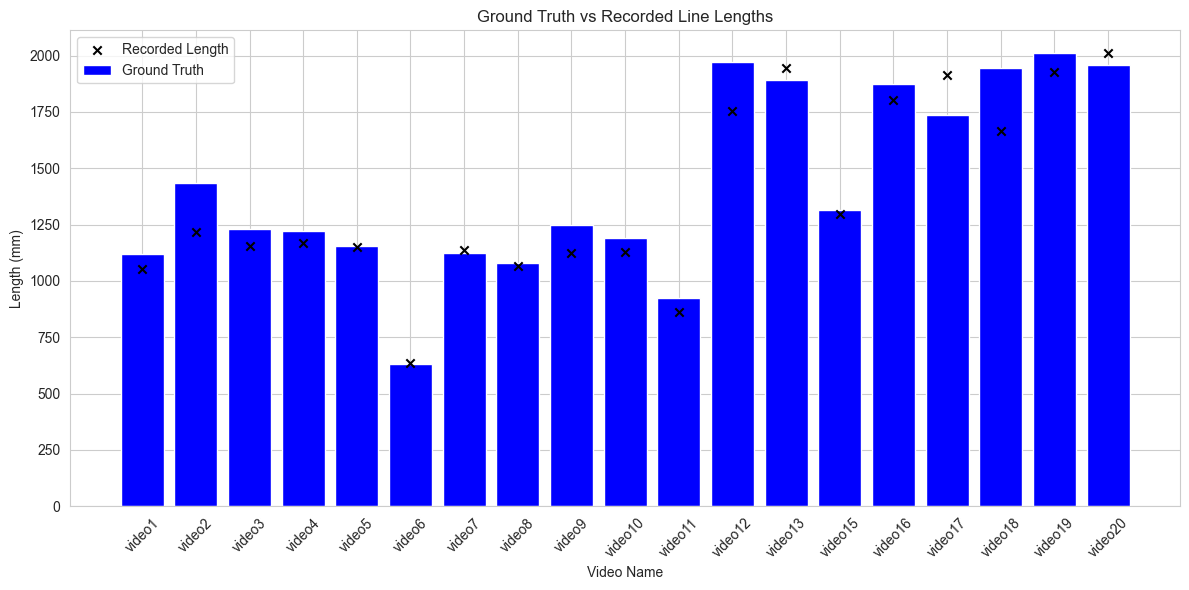

In [34]:
# Load the CSV files
ground_truth_df = pd.read_csv('./ground_truth_frames/marked_v2/ground_truth.csv')
recorded_lengths_df = pd.read_csv('./results/recorded_line_lengths.csv')

# Merge the dataframes on video_name
merged_df = pd.merge(ground_truth_df, recorded_lengths_df, on='video_name')

# Exclude video14 as it is an outlier
merged_df = merged_df[~merged_df['video_name'].isin(['video14'])]

# Calculate accuracy for each video
merged_df['accuracy'] = 1 - (abs(merged_df['recorded_line_length_mm'] - merged_df['ground_truth_mm']) / merged_df['ground_truth_mm'])

# Print recorded length, ground truth, and accuracy for each video
print("Recorded Length, Ground Truth, and Accuracy for each video:")

for index, row in merged_df.iterrows():
    print(f"Video: {row['video_name']}, Recorded Length: {row['recorded_line_length_mm']}, Ground Truth: {row['ground_truth_mm']}, Accuracy: {row['accuracy']:.2%}")

# Calculate overall accuracy
overall_accuracy = merged_df['accuracy'].mean()

# Print overall accuracy
print("\nOverall Accuracy: {:.2%}".format(overall_accuracy))

# Plotting
plt.figure(figsize=(12, 6))

# Plot ground truth as bar chart
plt.bar(merged_df['video_name'], merged_df['ground_truth_mm'], color='blue', label='Ground Truth')

# Plot recorded line lengths as black X
plt.scatter(merged_df['video_name'], merged_df['recorded_line_length_mm'], color='black', marker='x', label='Recorded Length')

# Add labels and title
plt.xlabel('Video Name')
plt.ylabel('Length (mm)')
plt.title('Ground Truth vs Recorded Line Lengths')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


Evaluate the results

C:\Users\steve\AppData\Local\Temp\ipykernel_143104\2232295061.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(merged_df['video_name'], rotation=45)


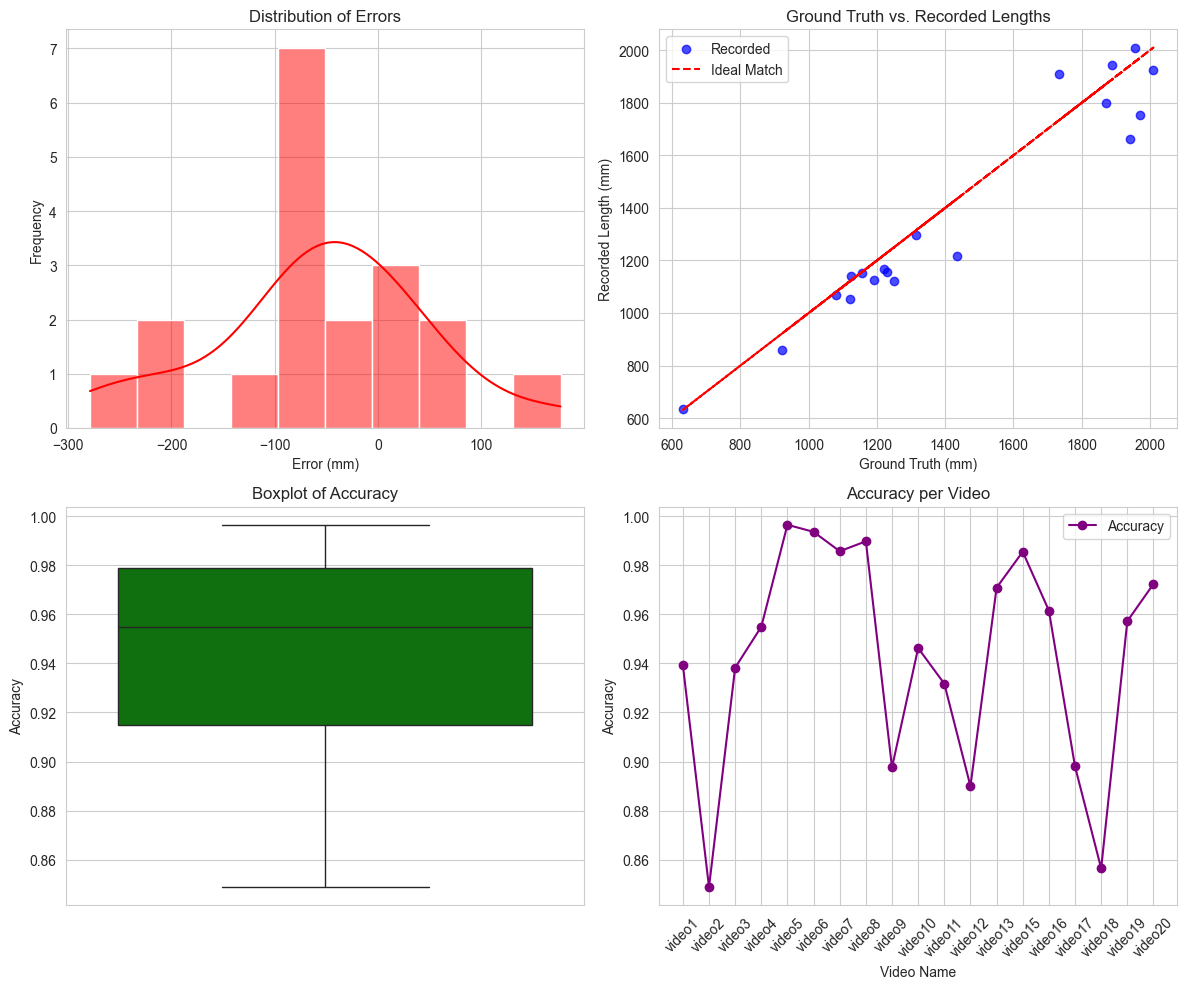

In [35]:
# Display the first few rows of each dataframe to inspect structure
#ground_truth_df.head(), recorded_lengths_df.head()

# Calculate error metrics
merged_df['error'] = merged_df['recorded_line_length_mm'] - merged_df['ground_truth_mm']
merged_df['absolute_error'] = abs(merged_df['error'])
merged_df['squared_error'] = merged_df['error'] ** 2

# Compute statistical values
mae = merged_df['absolute_error'].mean()  # Mean Absolute Error
mse = merged_df['squared_error'].mean()   # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
std_dev = merged_df['error'].std()  # Standard Deviation
mean_accuracy = merged_df['accuracy'].mean()  # Mean Accuracy
median_accuracy = merged_df['accuracy'].median()  # Median Accuracy

# Store results in a dictionary
stats_results = {
    "Mean Absolute Error (MAE)": mae,
    "Mean Squared Error (MSE)": mse,
    "Root Mean Squared Error (RMSE)": rmse,
    "Standard Deviation": std_dev,
    "Mean Accuracy": mean_accuracy,
    "Median Accuracy": median_accuracy
}

stats_results

# Statistical Analysis of the Results

# Mean Absolute Error (MAE): 88.37 mm
# On average, the recorded line length deviates from the ground truth by 88.37 mm.

# Mean Squared Error (MSE): 14,132.68 mm²
# This metric penalizes larger errors more heavily and provides an overall measure of error magnitude.

# Root Mean Squared Error (RMSE): 118.88 mm
# The RMSE gives an error magnitude in the same unit as the measurements, providing a more interpretable error metric.

# Standard Deviation: 107.65 mm
# Indicates the spread of errors, suggesting that the deviations from the ground truth vary significantly.

# Mean Accuracy: 94.29%
# On average, the recorded measurements are 94.25% accurate compared to the ground truth.

# Median Accuracy: 95.50%
# The middle value of accuracy scores, indicating that at least half of the videos have an accuracy above 95.50%.


# Set plot style
sns.set_style("whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram of Errors
sns.histplot(merged_df['error'], bins=10, kde=True, ax=axes[0, 0], color='red')
axes[0, 0].set_title('Distribution of Errors')
axes[0, 0].set_xlabel('Error (mm)')
axes[0, 0].set_ylabel('Frequency')

# Scatter plot of Ground Truth vs Recorded Lengths
axes[0, 1].scatter(merged_df['ground_truth_mm'], merged_df['recorded_line_length_mm'], color='blue', alpha=0.7, label='Recorded')
axes[0, 1].plot(merged_df['ground_truth_mm'], merged_df['ground_truth_mm'], 'r--', label='Ideal Match')
axes[0, 1].set_title('Ground Truth vs. Recorded Lengths')
axes[0, 1].set_xlabel('Ground Truth (mm)')
axes[0, 1].set_ylabel('Recorded Length (mm)')
axes[0, 1].legend()

# Boxplot of Accuracy
sns.boxplot(y=merged_df['accuracy'], ax=axes[1, 0], color='green')
axes[1, 0].set_title('Boxplot of Accuracy')
axes[1, 0].set_ylabel('Accuracy')

# Line plot of Accuracy per Video
axes[1, 1].plot(merged_df['video_name'], merged_df['accuracy'], marker='o', linestyle='-', color='purple', label='Accuracy')
axes[1, 1].set_title('Accuracy per Video')
axes[1, 1].set_xlabel('Video Name')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_xticklabels(merged_df['video_name'], rotation=45)
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Visual Analysis of Results
# Error Distribution (Top Left - Histogram)
# Errors are centered around zero, meaning the recorded values are relatively close to the ground truth.
# There is a slight negative bias, indicating that recorded lengths tend to be slightly underestimated.

# Ground Truth vs. Recorded Lengths (Top Right - Scatter Plot)
# The recorded lengths generally align with the ground truth (red dashed line).
# Some deviations are visible, especially for larger lengths.

# Accuracy Distribution (Bottom Left - Boxplot)
# Most accuracy values are above 90%, confirming that the system is highly reliable.
# A few outliers show lower accuracy, suggesting possible inconsistencies in certain cases.

# Accuracy per Video (Bottom Right - Line Plot)
# Accuracy varies across videos, with some dropping below 90%.
# Some videos have near-perfect accuracy, while others show inconsistencies.

# Key Takeaways
# The overall accuracy is quite high (94.29% on average).
# The recorded lengths generally align with the ground truth, but some outliers exist.
# The error distribution suggests a small systematic bias toward underestimation.
